In [999]:
import numpy as np
from pylab import *
import matplotlib
import matplotlib.pyplot as plt

### Activation Functions ###

$$ sigmoid(Z) = \frac{1}{1 + e^{-Z}} $$

In [1000]:
def sigmoid(Z, return_derivative=False):
    if return_derivative: 
        return np.multiply(sigmoid(Z), (1-sigmoid(Z)))
    else:
        return 1 / (1 + np.exp(-Z))

def tanh(Z, return_derivative=False):
    if return_derivative:
        return 1 - np.multiply(np.tanh(Z), np.tanh(Z))
    else:
        return np.tanh(Z)
        
    

In [1001]:
def initialize_weights_biases(nodes_per_layer, scale_term = 0.001):
    """

    :param nodes_per_layer: list where nodes_per_layer[i] = number of nodes in i
    :param scale_term: scaling factor, ensures that values of z remain close to 0
                        -> higher valued da/dz
                        -> faster learning
    :return:
    weights: list where weights[i] = W^[i]
    biases: list where biases[i] = b^[i]
    """

    weights = [None]
    biases  = [None]
    for i in range(1, len(nodes_per_layer)):
        weights.insert(i, np.random.randn(nodes_per_layer[i], nodes_per_layer[i-1]) * scale_term)
        biases.insert(i, np.zeros((nodes_per_layer[i], 1)))

    return weights, biases

In [1002]:
def forwardpropagate(weights, biases, activation_functions, num_layers, X):
    
    """
    :param weights: list where weights[i] = W^[i]
    :param biases: list where biases[i] = b^[i]
    :param num_layers: number of (non-input) layers in nn
    :param X: input matrix
    :return: 
    activations: list where activations[i] = A^[i]
    """

    def forwardpropagate_recurse(activations, Z_vals, layer = 1):
        A = activations[layer - 1]
        W = weights[layer]
        b = biases[layer]
        g = activation_functions[layer]
        
        Z = np.dot(W, A) + b
        activations.insert(layer, g(Z))
        Z_vals.insert(layer, g(Z))

        if layer == num_layers:
            return activations, Z_vals
        else:
            return forwardpropagate_recurse(activations, layer + 1)

    activations = [X.T]
    Z_vals = [None]
    return forwardpropagate_recurse(activations, Z_vals)

In [1003]:
def backpropagate(weights, biases, activations, Y):
    W1, W2  = weights[1], weights[2]
    b1, b2 = biases[1], biases[2]
    A0, A1, A2 = activations[0], activations[1], activations[2]
    m = Y.shape[1]
    
    dZ2 = A2 - Y.T
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis = 1, keepdims = True)
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = (1 / m) * np.dot(dZ1, A0.T)
    db1 = (1 / m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    
    weight_gradients = []
    weight_gradients.insert(0, None)
    weight_gradients.insert(1, dW1)
    weight_gradients.insert(2, dW2)
    
    bias_gradients = []
    bias_gradients.insert(0, None)
    bias_gradients.insert(1, b1)
    bias_gradients.insert(2, b2)
    
    return weight_gradients, bias_gradients

### Logistic Cost Function (Unregularized) ###


$$J(W, X, Y) = - \frac{1}{m} \sum\limits_{k=1}^K\sum\limits_{i=1}^m Y_k^{(i)}log(h_{W}(x^{(i)})_k) + (1 - Y_k^{(i)} )log(1- h_W(x^{(i)})_k) $$

In [1004]:
def compute_cost_logistic(yhat, Y, return_derivative=False):
    assert(yhat.shape == Y.shape)
    m = Y.shape[0]

    return (-1 / m) * np.sum(np.dot(Y.T, np.log(yhat)) + np.dot((1 - Y).T, np.log(1 - yhat)))
    

In [ ]:
def predict(yhat, threshold):
    predictions = (yhat > threshold)
    return predictions


def cross_validate(weights, biases, activation_functions, num_layers, threshold = 0.5):
    X_test = np.random.randint(20, size = (20, 2))
    Y_test = np.multiply(X_test[:, [0]], X_test[:, [1]]) % 2 == 0

    activations = [X_test.T]
    activations = forwardpropagate(weights, biases, activation_functions, num_layers, X_test)
    yhat = activations[num_layers]
    predictions = predict(yhat, threshold)
    accuracy = np.mean(predictions == Y_test)
    return accurac

In [1005]:
def model_nn(X, Y, nodes_per_layer, activation_functions, learning_rate=0.005, num_iterations=20, step_rate = 2):
    weights, biases = initialize_weights_biases(nodes_per_layer)
    num_layers = len(nodes_per_layer) - 1

    iteration_vals = []
    accuracy_vals = []
    cost_vals = []
    for i in range(num_iterations):
        activations, Z_vals = forwardpropagate(weights, biases, activation_functions, num_layers, X)
        weight_gradients, bias_gradients = backpropagate(weights, biases, activations, Z_vals, Y)

        if i % step_rate == 0:
            accuracy = cross_validate(weights, biases, activation_functions, num_layers)
            cost = compute_cost_logistic(activations[num_layers].T, Y)
            iteration_vals.append(i)
            accuracy_vals.append(accuracy)
            cost_vals.append(cost)

        for layer in range(1, len(nodes_per_layer)):
            weights[layer] -= learning_rate * weight_gradients[layer]
            biases[layer] -= learning_rate * bias_gradients[layer]

    return weights, biases, iteration_vals, accuracy_vals, cost_vals

In [1006]:
learning_rate = 0.0005
num_iterations = 200
step_rate = 15
m_train = 500

X = np.random.randint(30, size = (m_train, 2))
Y = np.multiply(X[:, [0]], X[:, [1]]) % 2 == 0
n_x = X.shape[1]
n_h = 3
n_y = Y.shape[1]
activation_functions = [None, np.tanh, sigmoid]
nodes_per_layer = [n_x, n_h, n_y]

weights, biases, iterations, accuracy_vals, cost_vals = model_nn(X, Y, nodes_per_layer, activation_functions, learning_rate, num_iterations, step_rate)

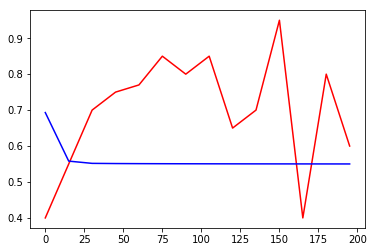

In [1007]:
figure()
plot(iterations, accuracy_vals, 'r')
plot(iterations, cost_vals, 'b')
show()